In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image, UnidentifiedImageError
import os
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import random
from collections import Counter

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 16
NUM_CLASSES = 20
EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.00002683
IMAGE_SIZE = 224
DATASET_PATH = '/kaggle/input/d/phiard/aksara-jawa/v3/v3'  # Sesuaikan dengan path dataset Anda

In [2]:
# --- Dataset Custom untuk Aksara Jawa ---
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(root)
        self.num_classes = len(self.classes)

        for target_class in sorted(self.class_to_idx.keys()):
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(root, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root_, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root_, fname)
                    try:
                        with Image.open(path) as img:
                            img.verify()  # Verifikasi integritas gambar
                        self.samples.append((path, class_index))
                        self.targets.append(class_index)
                    except (UnidentifiedImageError, OSError):
                        print(f"Gambar korup dilewati: {path}")
                        continue

    def __getitem__(self, index):
        path, target = self.samples[index]
        with Image.open(path) as sample:
            sample = sample.convert('RGB')

        if self.transform:
            sample = self.transform(sample)

        return sample, target

    def __len__(self):
        return len(self.samples)

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx



In [3]:
# --- Persiapan Dataset & DataLoader ---
train_dir = os.path.join(DATASET_PATH, 'train')
val_dir = os.path.join(DATASET_PATH, 'val')

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomImageFolder(train_dir, transform=train_transform)
val_dataset = CustomImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4, pin_memory=True)

# Verifikasi distribusi kelas
counter = Counter(train_dataset.targets)
print("Distribusi Kelas dalam Training Set:")
for cls, count in counter.items():
    print(f"Kelas {cls}: {count} sampel")

# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.targets),
    y=train_dataset.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")


Distribusi Kelas dalam Training Set:
Kelas 0: 114 sampel
Kelas 1: 108 sampel
Kelas 2: 108 sampel
Kelas 3: 108 sampel
Kelas 4: 108 sampel
Kelas 5: 102 sampel
Kelas 6: 108 sampel
Kelas 7: 108 sampel
Kelas 8: 108 sampel
Kelas 9: 108 sampel
Kelas 10: 108 sampel
Kelas 11: 102 sampel
Kelas 12: 108 sampel
Kelas 13: 108 sampel
Kelas 14: 108 sampel
Kelas 15: 108 sampel
Kelas 16: 108 sampel
Kelas 17: 108 sampel
Kelas 18: 108 sampel
Kelas 19: 108 sampel
Class Weights: tensor([0.9447, 0.9972, 0.9972, 0.9972, 0.9972, 1.0559, 0.9972, 0.9972, 0.9972,
        0.9972, 0.9972, 1.0559, 0.9972, 0.9972, 0.9972, 0.9972, 0.9972, 0.9972,
        0.9972, 0.9972], device='cuda:0')


In [4]:
# --- Model CNN (ResNet-50) dengan Transfer Learning ---
resnet_model = models.resnet50(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Pastikan semua parameter dioptimalkan
for param in resnet_model.parameters():
    param.requires_grad = True

resnet_model = resnet_model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s] 


In [5]:
# --- Definisikan Loss, Optimizer, dan Scheduler ---
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.0)
optimizer = optim.AdamW(resnet_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


In [6]:
# --- Fungsi Training per Epoch ---
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

    return total_loss / len(loader), 100. * correct / total


In [7]:
# --- Fungsi Validasi ---
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_targets, all_predictions, average='weighted')
    return total_loss / len(loader), 100. * correct / total, f1, all_targets, all_predictions



In [8]:
# --- TensorBoard Writer (opsional) ---
writer = SummaryWriter()


In [9]:
# --- List untuk Menyimpan Metrik per Epoch ---
train_losses = []
train_accs = []
val_losses = []
val_accs = []
val_f1_scores = []

patience = 5
counter_no_improve = 0
best_val_acc = 0


In [10]:
# --- Loop Training ---
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(resnet_model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, all_targets, all_predictions = validate(resnet_model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1_scores.append(val_f1)

    # Logging ke TensorBoard
    writer.add_scalars('Loss', {'Train': train_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc, 'Val': val_acc}, epoch)
    writer.add_scalar('F1_Score/Val', val_f1, epoch)

    # Simpan model jika ada perbaikan akurasi
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet_model.state_dict(), "best_resnet_model.pth")
        counter_no_improve = 0
    else:
        counter_no_improve += 1

    # Early stopping
    if counter_no_improve >= patience:
        print(f"Early stopping setelah epoch {epoch+1} karena tidak ada peningkatan akurasi validasi.")
        break

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1 Score: {val_f1:.4f}")

    scheduler.step()

writer.close()


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/100
Train Loss: 0.9033, Train Acc: 72.66%
Val Loss: 1.8570, Val Acc: 38.96%, Val F1 Score: 0.3565


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/100
Train Loss: 0.2333, Train Acc: 93.41%
Val Loss: 0.3378, Val Acc: 87.92%, Val F1 Score: 0.8811


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/100
Train Loss: 0.1447, Train Acc: 96.10%
Val Loss: 0.1122, Val Acc: 96.46%, Val F1 Score: 0.9648


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/100
Train Loss: 0.0668, Train Acc: 98.24%
Val Loss: 0.0840, Val Acc: 96.67%, Val F1 Score: 0.9661


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/100
Train Loss: 0.0446, Train Acc: 98.70%
Val Loss: 0.1368, Val Acc: 95.62%, Val F1 Score: 0.9559


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/100
Train Loss: 0.0366, Train Acc: 99.26%
Val Loss: 0.1857, Val Acc: 96.88%, Val F1 Score: 0.9687


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/100
Train Loss: 0.1621, Train Acc: 94.99%
Val Loss: 0.3827, Val Acc: 89.38%, Val F1 Score: 0.8851


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/100
Train Loss: 0.0863, Train Acc: 97.45%
Val Loss: 0.2610, Val Acc: 90.83%, Val F1 Score: 0.9096


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/100
Train Loss: 0.0493, Train Acc: 98.24%
Val Loss: 0.0691, Val Acc: 97.29%, Val F1 Score: 0.9729


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/100
Train Loss: 0.0049, Train Acc: 99.95%
Val Loss: 0.0325, Val Acc: 99.17%, Val F1 Score: 0.9916


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/100
Train Loss: 0.0329, Train Acc: 99.07%
Val Loss: 0.0964, Val Acc: 97.29%, Val F1 Score: 0.9731


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/100
Train Loss: 0.0272, Train Acc: 99.12%
Val Loss: 0.7400, Val Acc: 86.46%, Val F1 Score: 0.8460


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/100
Train Loss: 0.0552, Train Acc: 98.42%
Val Loss: 0.0268, Val Acc: 99.17%, Val F1 Score: 0.9917


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/100
Train Loss: 0.0067, Train Acc: 99.86%
Val Loss: 0.0292, Val Acc: 99.38%, Val F1 Score: 0.9937


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/100
Train Loss: 0.0040, Train Acc: 99.95%
Val Loss: 0.2525, Val Acc: 91.25%, Val F1 Score: 0.8981


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/100
Train Loss: 0.0903, Train Acc: 97.73%
Val Loss: 0.2263, Val Acc: 94.17%, Val F1 Score: 0.9409


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/100
Train Loss: 0.1349, Train Acc: 96.89%
Val Loss: 1.3136, Val Acc: 73.33%, Val F1 Score: 0.7362


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/100
Train Loss: 0.0477, Train Acc: 98.61%
Val Loss: 0.0490, Val Acc: 98.33%, Val F1 Score: 0.9833


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Early stopping setelah epoch 19 karena tidak ada peningkatan akurasi validasi.


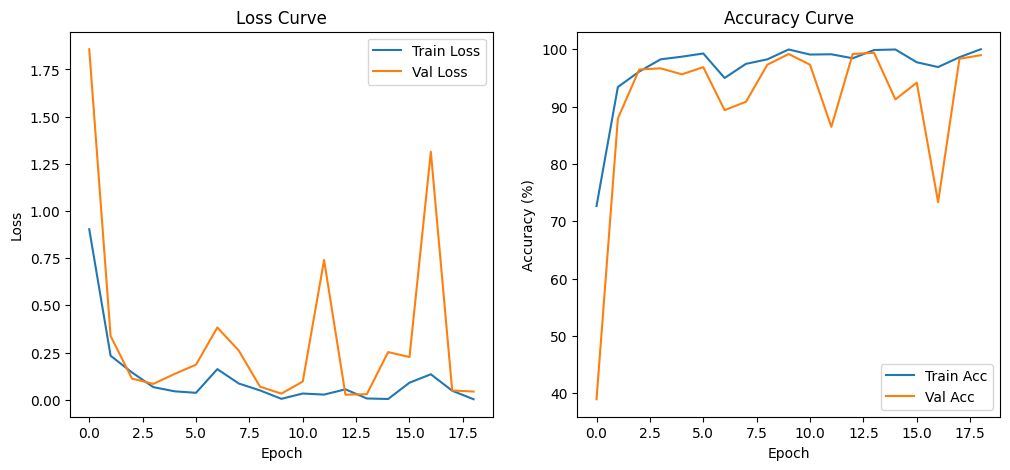

In [11]:
# --- Plot Loss & Accuracy ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_accs)), train_accs, label='Train Acc')
plt.plot(range(len(val_accs)), val_accs, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


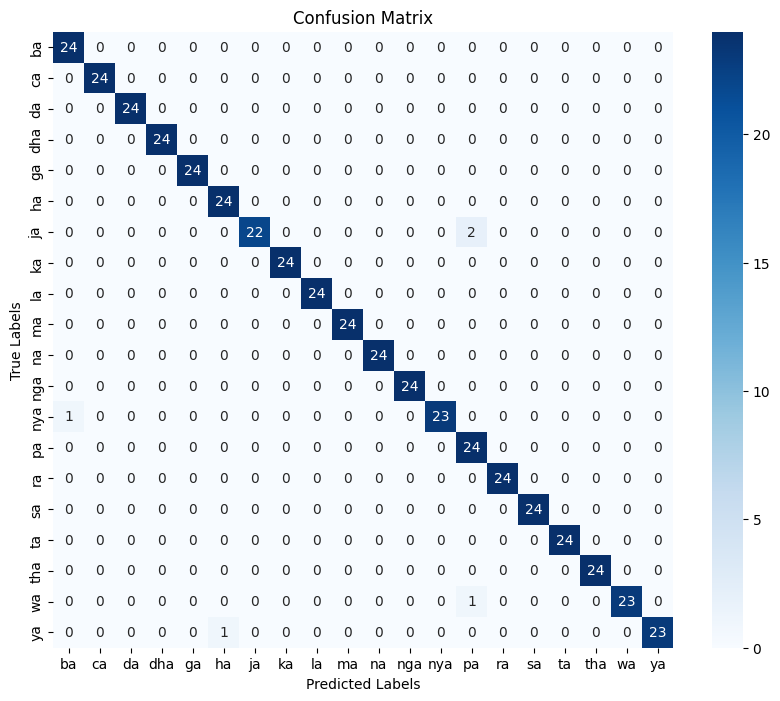

Classification Report:
              precision    recall  f1-score   support

          ba       0.96      1.00      0.98        24
          ca       1.00      1.00      1.00        24
          da       1.00      1.00      1.00        24
         dha       1.00      1.00      1.00        24
          ga       1.00      1.00      1.00        24
          ha       0.96      1.00      0.98        24
          ja       1.00      0.92      0.96        24
          ka       1.00      1.00      1.00        24
          la       1.00      1.00      1.00        24
          ma       1.00      1.00      1.00        24
          na       1.00      1.00      1.00        24
         nga       1.00      1.00      1.00        24
         nya       1.00      0.96      0.98        24
          pa       0.89      1.00      0.94        24
          ra       1.00      1.00      1.00        24
          sa       1.00      1.00      1.00        24
          ta       1.00      1.00      1.00        24
    

In [12]:
# --- Confusion Matrix & Classification Report (untuk hasil akhir) ---
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_targets, all_predictions,
                            target_names=train_dataset.classes))


In [13]:
# ------------------------------------------------------------------
# FUNGSI UNTUK MEMUAT MODEL DAN MELAKUKAN PREDIKSI
# ------------------------------------------------------------------

def load_model(model_path="best_resnet_model.pth", num_classes=NUM_CLASSES, device=device):
    """
    Fungsi untuk memuat model ResNet-50 terlatih dari file .pth
    """
    # Inisialisasi model dengan arsitektur dan output layer yang sama
    model = models.resnet50(pretrained=False)  # pre-trained=False, karena bobot akan diganti
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def predict_image(model, image_path, transform, classes, device=device):
    """
    Fungsi untuk memprediksi satu gambar.
    Args:
        model: model yang telah diload
        image_path: path ke gambar
        transform: transformasi yang sama seperti dataset
        classes: daftar kelas (train_dataset.classes)
    Return:
        pred_class: nama kelas yang diprediksi
    """
    # Pastikan mode eval
    model.eval()
    with torch.no_grad():
        img = Image.open(image_path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)  # tambah dimensi batch
        output = model(img)
        _, predicted = output.max(1)
        pred_class = classes[predicted.item()]
    return pred_class



In [18]:
 model_loaded = load_model("best_resnet_model.pth")
 hasil_prediksi = predict_image(model_loaded, "/kaggle/input/javanese-script-aksara-jawa-augmented/test/ba/ba96.mine3.b.png", val_transform, train_dataset.classes)
 print("Prediksi Aksara:", hasil_prediksi)


Prediksi Aksara: ba


/tmp/ipykernel_30/2861218559.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
